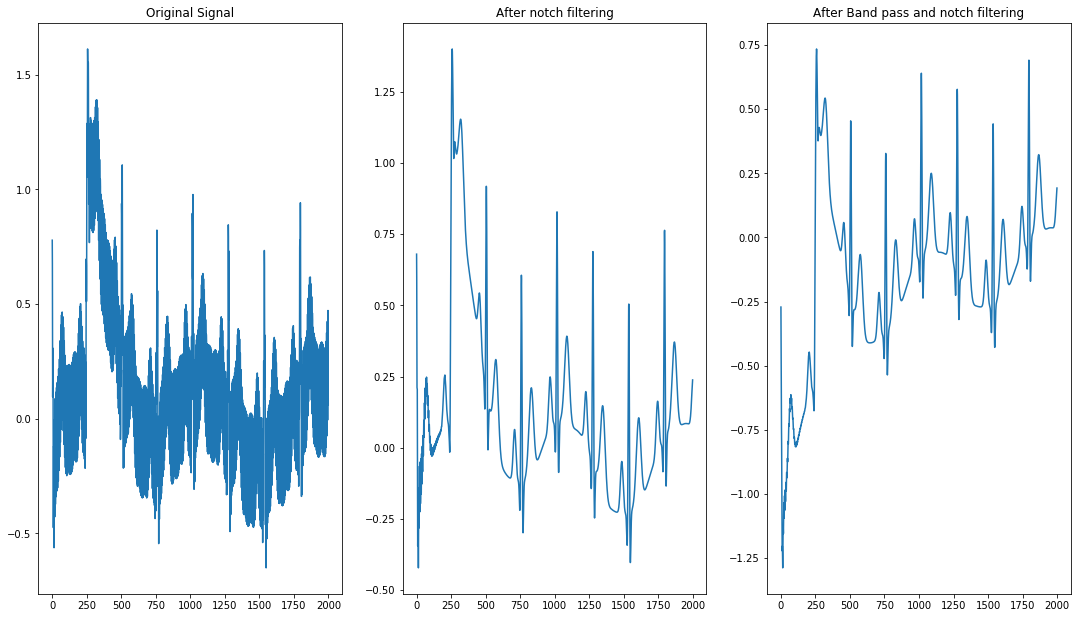

DetectedR_5.jpg


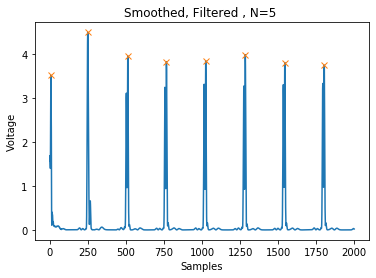

DetectedR_15.jpg


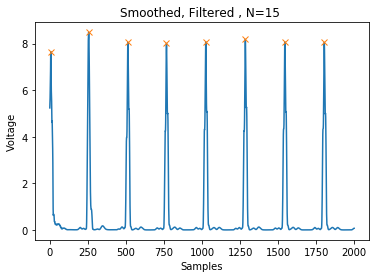

DetectedR_25.jpg


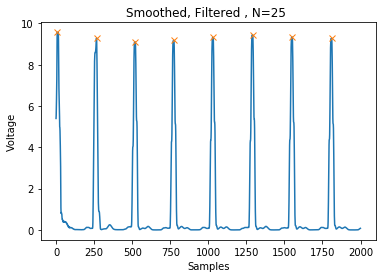

Unfiltered_25.jpg


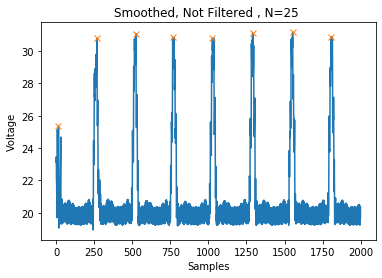

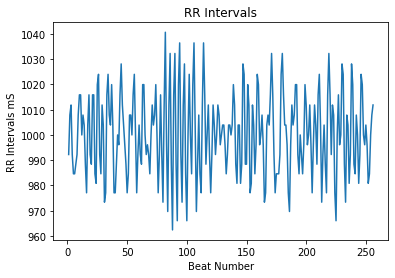

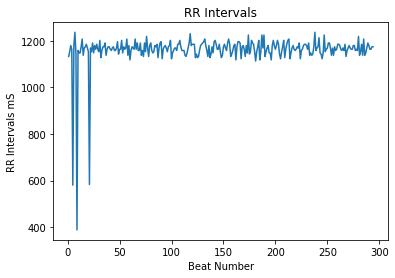

Missing Beat At
1120.0
Missing Beat At
2318.0
Missing Beat At
5282.0
Missing Beats in seconds
[4.373046875, 9.052734375, 20.634765625]


In [3]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import find_peaks


data = pd.read_csv('dataN.txt', header = None)
data2 = pd.read_csv('data2.txt', header = None)


def NotchFilter(data):
    fs = 256.0  # Sample frequency (Hz)
    f0 = 50.0  # Frequency to be removed from signal (Hz)
    Q =  30  # Quality factor
    w0 = f0 / (fs / 2 )  # Normalized Frequency
    b, a = signal.iirnotch(f0,Q,fs )
    data = signal.filtfilt(b, a, data,axis=0)
    return data


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(1, [low, high], btype='band')
    return b, a
def Bandpass(data):
    b, a = butter_bandpass(0.1, 45, 256)
    y = signal.filtfilt(b, a, data,axis=0)
    return y
#plt.figure(figsize=(15,10)) 

def Filter(data):
    NotchFiltered=NotchFilter(data);
    BandFiltered=Bandpass(NotchFiltered);
    return BandFiltered;


def PlotFiltered(data):
    NotchFiltered=NotchFilter(data);
    BandFiltered=Bandpass(NotchFiltered);
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
    ax1.plot(data[0:2000])
    ax1.set_title('Original Signal')
    #ax1.ylabel('Voltage')
    #ax1.xlabel('Samples')
    ax2.plot(NotchFiltered[0:2000])
    ax2.set_title('After notch filtering')
    #ax2.ylabel('Voltage')
    #ax2.xlabel('Samples')
    ax3.plot(BandFiltered[0:2000])
    ax3.set_title('After Band pass and notch filtering')
    #ax3.ylabel('Voltage')
    #ax3.xlabel('Samples')
    fig.set_size_inches(18.5, 10.5)
    plt.savefig('Before_After_Filter.jpg')
    plt.show()
    return BandFiltered;

    


def differentiate(BandFiltered):
    NewArray =np.copy(BandFiltered)
    for i in range(4, len(BandFiltered)-2):
        #print(NewArray[i])
        NewArray[i]=(-1*BandFiltered[i-2]-2*BandFiltered[i-1]+1*BandFiltered[i+2]+2*BandFiltered[i+1])
    return NewArray

def Square(differentiated):
    return np.square(differentiated)


def SmoothWithWindow(data,Window=25):
    Filtered=Filter(data)
    Filtered=differentiate(Filtered)
    squared=Square(Filtered)
    NewArray =np.copy(squared)
    for i in range(0,len(squared)):
        NewArray[i]=0
        for j in range(0,Window):
            NewArray[i]+=squared[i-j]
    return NewArray

    
def SkipFilter(data,Window=25):
    Filtered=differentiate(data)
    squared=Square(Filtered)
    NewArray =np.copy(squared)
    for i in range(0,len(squared)):
        NewArray[i]=0
        for j in range(0,Window):
            NewArray[i]+=squared[i-j]
    return NewArray
    



def RRIntervals(data,savingName=None,Window=25):
    smoothed=SmoothWithWindow(data)
    ThresholdRpeak=(0.6)*np.max(smoothed)
    peaks, _ = find_peaks(smoothed.flatten(),height=ThresholdRpeak, distance=200)
    #print(peaks)
    BeatNumber=np.zeros(len(peaks))
    RR=np.zeros(len(peaks))
    FF=np.zeros(len(peaks))
    for i in range(1,len(peaks)):
        BeatNumber[i]=i
        FF[i]=peaks[i]-peaks[i-1]
        RR[i]=(1/FF[i])*1000*256
    RR=RR[1:]
    BeatNumber=BeatNumber[1:]
    plt.plot(BeatNumber, RR)  
    plt.title('RR Intervals')
    plt.ylabel('RR Intervals mS')
    plt.xlabel('Beat Number')
    plt.savefig(savingName)
    plt.show()
    return FF,peaks


    
    
    

def Plot(smoothed,title,savingName=None,Window=25):
    ThresholdRpeak=(0.6)*np.max(smoothed)
    #print(ThresholdRpeak)
    peaks, _ = find_peaks(smoothed[0:2000].flatten(),height=ThresholdRpeak, distance=200)
    plt.plot(smoothed[0:2000])
    plt.plot(peaks, smoothed[peaks], "x")
    plt.title(title)
    plt.ylabel('Voltage')
    plt.xlabel('Samples')
    print(savingName)
    plt.savefig(savingName)
    plt.show()
    


#RRIntervals(data)
      
def MissingBeats(data,savingName,Window=25):
    Intervals,peaks=RRIntervals(data,savingName,Window)
    Smoothed=SmoothWithWindow(data,Window)
    average= np.average(Intervals)
    #print(Intervals)
    #print(average)
    output=[]
    seconds=[]
    with open('MissingBeats.txt', 'w',newline='') as f:
        for i in range(1,len(peaks)):
            difference=peaks[i]-peaks[i-1]
            if(difference>average*1.7):
                print("Missing Beat At")
                print(round((peaks[i]+peaks[i-1])/(2)))
                output=output+[round((peaks[i]+peaks[i-1])/(2))]
                seconds=seconds+[(peaks[i]+peaks[i-1])/(2*256)]
        writer = csv.writer(f)
        #print(output)
        print("Missing Beats in seconds")
        print(seconds)
        writer.writerow(output)




if __name__ == "__main__":
    
    PlotFiltered = PlotFiltered(data)
    smoothed=SmoothWithWindow(data,Window=5)
    Plot(smoothed,"Smoothed, Filtered , N=5 ","DetectedR_5.jpg")
    smoothed=SmoothWithWindow(data,Window=15)
    Plot(smoothed,"Smoothed, Filtered , N=15 ","DetectedR_15.jpg")
    smoothed=SmoothWithWindow(data,Window=25)
    Plot(smoothed,"Smoothed, Filtered , N=25 ","DetectedR_25.jpg")
    SkipFilter =SkipFilter(data[0])
    Plot(SkipFilter,"Smoothed, Not Filtered , N=25 ","Unfiltered_25.jpg")
    RRIntervals(data,"RR.jpg",25)
    
    MissingBeats(data2,"RR2.jpg",Window=25)


